In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/hw3

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/hw3


# **Task 1:  Sequence Tagging with RNNs**

In this task, you will implement LSTM and Bi-LSTM architectures with PyTorch to perform part-of-speech tagging (a sequence tagging task).

### **Data**
We use a subset of the data from the CoNLL-2003 shared task on Named Entity Recognition (provided in the zip). It is pre-partioned into a training, development and test set.

The dataset consists of pre-tokenized sentences where every token is annotated with a part-of-speech tag, a syntactic chunk tag and a named entity tag. In this home exercise, we only use the IOB named entity recognition tag.

In [2]:
import torch
import torch.nn as nn
import os
import re
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

In [ ]:
def seed_everything(seed: int):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type(torch.FloatTensor) #added to avoid datatype problems

In [ ]:
seed_everything(seed=999)

## **Task 1.1: Pretrained Embeddings (5p)**

Download the pretrained, uncased GloVe embeddings with 6B tokens [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) from Stanford.

For performance reasons, we will only use the 50-dimensional embeddings **glove.6B.50d.txt**.

Implement a function to read the embedding and another function to read the dataset.

In [3]:
# https://medium.com/analytics-vidhya/ner-tensorflow-2-2-0-9f10dcf5a0a
"""
  Store each sentence seperately. Each token of the sentences is stored with its corresponding IOB named entity recognition tag
"""

def split_text_label(filename):
  f = open(filename)
  split_labeled_text = []
  sentence = []
  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
       if len(sentence) > 0:
         split_labeled_text.append(sentence)
         sentence = []
       continue
    splits = line.split(' ')
    sentence.append([splits[0],splits[-1].rstrip("\n")])
  if len(sentence) > 0:
    split_labeled_text.append(sentence)
    sentence = []
  return split_labeled_text

In [4]:
def read_data(path):
    data = defaultdict(list)
    label = defaultdict(list)
    # TODO: YOUR CODE HERE

    text_label = split_text_label(filename=path)
    for idx, sent in enumerate(text_label):
      words = []
      iob_labels = []
      for word_iob in sent:
        words.append(word_iob[0]) #add word
        iob_labels.append(word_iob[1]) #add iob tag

      data[idx] = words
      label[idx] = iob_labels

    return data, label

def get_pretrained_embeddings(embedding_path):
    embeddings = defaultdict(list)
    # TODO: YOUR CODE HERE
    with open("glove.6B.50d.txt", "r") as file:
      for line in file:
        line = line.strip()
        word = line.split(" ")[0]
        vector = np.array([float(n) for n in line.split(" ")[1:]])

        embeddings[word] = vector

    return embeddings

In [5]:
embed = get_pretrained_embeddings(embedding_path="glove.6B.50d.txt")

In [50]:
embed["cricket"]

array([-1.2233   , -0.28292  , -1.7429   ,  0.56621  , -0.13787  ,
       -0.88088  , -0.26887  ,  0.41893  ,  0.94977  , -0.61332  ,
        0.0092522,  1.0045   , -0.89004  , -0.55148  ,  0.61202  ,
        0.42256  ,  0.92935  ,  0.83307  , -1.5568   ,  0.084345 ,
       -0.018224 ,  0.84803  ,  0.68321  ,  0.97059  ,  0.26561  ,
       -1.0538   ,  0.40724  , -0.45079  , -0.89013  ,  0.94153  ,
        2.2055   ,  0.75363  ,  0.5166   ,  0.47977  ,  0.86824  ,
        0.57228  ,  0.81846  , -0.070934 , -0.9391   , -0.81628  ,
       -0.35486  , -0.010408 , -0.83316  ,  1.1001   , -0.087408 ,
        1.8452   , -0.83112  ,  0.43732  ,  0.63007  , -0.81023  ])

In [6]:
embed["get"].shape[0]

50

In [7]:
out= split_text_label("data/ner_eng_bio.train")

In [8]:
out[2]

[['BRUSSELS', 'B-LOC'], ['1996-08-22', 'O']]

In [9]:
data, label = read_data("data/ner_eng_bio.train")

In [10]:
data[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [11]:
label[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [12]:
counter = 0
with open("data/ner_eng_bio.train", "r") as file:
    for line in file:
      print(line.strip().split(" "))
      if counter == 10:
        break
      counter += 1

['EU', 'NNP', 'B-NP', 'B-ORG']
['rejects', 'VBZ', 'B-VP', 'O']
['German', 'JJ', 'B-NP', 'B-MISC']
['call', 'NN', 'I-NP', 'O']
['to', 'TO', 'B-VP', 'O']
['boycott', 'VB', 'I-VP', 'O']
['British', 'JJ', 'B-NP', 'B-MISC']
['lamb', 'NN', 'I-NP', 'O']
['.', '.', 'O', 'O']
['']
['Peter', 'NNP', 'B-NP', 'B-PER']


In [13]:
"""dataset = defaultdict(list)
labels = defaultdict(list)
with open("data/ner_eng_bio.train", "r") as file:
    sentence = []
    sentence_labels = []
    for line in file:
        line = line.strip()
        if line == "":
            if sentence:
                for word, label in zip(sentence, sentence_labels):
                    dataset["words"].append(word)
                    labels["tags"].append(label)
            sentence = []
            sentence_labels = []
        else:
            word, _, _, label = line.split()
            sentence.append(word)
            sentence_labels.append(label)"""

'dataset = defaultdict(list)\nlabels = defaultdict(list)\nwith open("data/ner_eng_bio.train", "r") as file:\n    sentence = []\n    sentence_labels = []\n    for line in file:\n        line = line.strip()\n        if line == "":\n            if sentence:\n                for word, label in zip(sentence, sentence_labels):\n                    dataset["words"].append(word)\n                    labels["tags"].append(label)\n            sentence = []\n            sentence_labels = []\n        else:\n            word, _, _, label = line.split()\n            sentence.append(word)\n            sentence_labels.append(label)'

## **Task 1.2: LSTM and Bi-LSTM Model (10p)**

We will use PyTorch to build our LSTM. Complete the `__init__()` and the `forward()` function of the CustomLSTM class. The model will have the following components:
- A single [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer which takes the embeddings as input and has 100-dimensional hidden layer. The LSTM is **not** bidirectional.
- A dropout layer with probability 0.1
- A linear layer with input size of 100 (the hidden layer size of the LSTM layer) and output size of the number of labels
- A [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function

In [14]:
from torch.nn.modules import dropout
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_labels):
        super(CustomLSTM, self).__init__()
        # TODO: YOUR CODE HERE
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_labels = num_labels

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.1, bidirectional=False)
        self.linear = nn.Linear(in_features=100, out_features=num_labels) # replace 100 with hidden_size maybe
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: YOUR CODE HERE
        #LSTM’s output corresponding to all timesteps
        output, (h_n, c_n) = self.lstm(x)
        last_hidden_state = output[-1] # can also be h_n   see https://towardsdatascience.com/implementation-differences-in-lstm-layers-tensorflow-vs-pytorch-77a31d742f74#:~:text=The%20output%20of%20the%20Pytorch,another%20tuple%20with%20two%20elements.
        linear_output = self.linear(last_hidden_state)
        output = self.sigmoid(linear_output)

        return output

## **Task 1.3: Training Model (10p)**

Complete the function `train` to train your model. The model will train with batch size of 1 (each sentence split by "\n" is a sample) for 10 epochs. You will train the model with the train dataset and use dev dataset to check the model's performance after each epoch. Calculate the macro f1 score of the model on the dev set. Return the losses and f1 scores for plotting.

**Hint**: you can check out this [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) to get to know more about how to train model with pytorch. For the f1 score you can use `sklearn.metrics.f1_score`, remember to set the `average` parameter to "macro".


In [15]:
def label_encode(labels):
    labels_list = {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7,
                   'O': 8}
    labels_encode = [labels_list[label] for label in labels]
    return labels_encode

In [16]:
# Change this to your path to the dataset
train = "data/ner_eng_bio.train"
test = "data/ner_eng_bio.test"
dev = "data/ner_eng_bio.dev"

embeddings = get_pretrained_embeddings("embeddings/glove.6B.50d.txt")

train_data, train_label = read_data(train)
test_data, test_label = read_data(test)
dev_data, dev_label = read_data(dev)

EMBEDDING_SIZE = embeddings["get"].shape[0]

# Change the Hyperparameters here
input_size = EMBEDDING_SIZE
hidden_size = 100
num_layers = 2
num_labels = 9
epochs = 10

In [17]:
len(dev_data[0]), len(dev_label[0])

(12, 12)

In [18]:
test_data[0]

['CRICKET',
 '-',
 'LEICESTERSHIRE',
 'TAKE',
 'OVER',
 'AT',
 'TOP',
 'AFTER',
 'INNINGS',
 'VICTORY',
 '.']

In [19]:
test_label[0]

['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [20]:
aa = []
bb = [1, 2, 3]
aa.append(bb)
aa

[[1, 2, 3]]

In [21]:
array = np.random.random((1, 3, 50))
array

array([[[0.53099871, 0.35476596, 0.37474979, 0.14181765, 0.92236944,
         0.85347238, 0.24514636, 0.13464598, 0.7066796 , 0.72900607,
         0.80926572, 0.89628043, 0.08364743, 0.99876657, 0.01073139,
         0.15810132, 0.93226799, 0.62566491, 0.44922831, 0.21076865,
         0.68286499, 0.01587166, 0.37573141, 0.9508861 , 0.55282506,
         0.67532812, 0.5038687 , 0.17945153, 0.2482623 , 0.48664983,
         0.03979727, 0.7784577 , 0.67064714, 0.79767907, 0.97922181,
         0.09217883, 0.57503463, 0.02763395, 0.30180791, 0.61859964,
         0.35249407, 0.49783019, 0.22709761, 0.2916266 , 0.67195445,
         0.14229556, 0.00759633, 0.53784823, 0.0563205 , 0.44924828],
        [0.75893553, 0.05502187, 0.24352694, 0.50609601, 0.19529347,
         0.74071594, 0.2350438 , 0.08214195, 0.16222079, 0.88790136,
         0.46177236, 0.85326981, 0.70136724, 0.92157609, 0.95578979,
         0.31857857, 0.86222316, 0.01146537, 0.70101102, 0.46301315,
         0.99729344, 0.84992842, 

In [37]:
def get_sentence_embeddings(sent: list, embeddings_dict: dict):
  out_sentence = []
  for token in sent:
    if token.lower() in embeddings_dict.keys():
      out_sentence.append(embeddings_dict[token.lower()])
    else:
      out_sentence.append(np.array([0]*50))
  return out_sentence

In [39]:
outt = get_sentence_embeddings(sent=train_data[0], embeddings_dict=embeddings)

In [42]:
len(outt)

9

In [24]:
len(train_data)

4434

In [25]:
torch.tensor(np.array([outt])).size()

torch.Size([1, 9, 50])

In [26]:
torch.tensor([[[1, 2, 3, 4]]]).size()

torch.Size([1, 1, 4])

In [43]:
model = CustomLSTM(input_size, hidden_size, num_layers, num_labels)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def train(model, loss_fn, optimizer, train_data, dev_data, train_label, dev_label, epochs):
    logs_loss = []
    logs_f1_score = []

    # Training
    for epoch in range(epochs):
        # Train with train set
        model.train()
        # TODO: YOUR CODE HERE
        print('EPOCH {}:'.format(epoch + 1))
        train_loss = 0.0

        for k, sent in train_data.items():
          optimizer.zero_grad()


          sent_embedding = get_sentence_embeddings(sent=sent, embeddings_dict=embeddings)
          input_data = torch.tensor(np.array([sent_embedding]), dtype=torch.float32) # Remove the last label
          targets = torch.tensor(label_encode(train_label[k]))

          # Forward pass
          outputs = model(input_data)
          loss = loss_fn(outputs, targets)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
        average_loss = train_loss / len(train_data) #calculate average loss value of the whole dataset
        logs_loss.append(average_loss)

        print(f"Finished epoch {epoch+1}")




        # Evaluate with dev set
        """with torch.no_grad():
            model.eval()
            # TODO: YOUR CODE HERE
            dev_loss = 0.0
            dev_preds = []
            dev_targets = []

            for k, sent in dev_data.items():
              sent_embedding_dev = get_sentence_embeddings(sent=sent, embeddings_dict=embeddings)
              input_data_dev = torch.tensor(np.array([sent_embedding_dev]), dtype=torch.float32) # Remove the last label
              targets = torch.tensor(label_encode(dev_label[k]))

              # Forward pass
              outputs = model(input_data)
              loss = loss_fn(outputs, targets)
              dev_loss += loss.item()

              # Convert predictions and targets to numpy arrays
              predictions = torch.argmax(outputs, dim=1).numpy()
              targets = targets.numpy()

              dev_preds.extend(predictions)
              dev_targets.extend(targets)

            average_dev_loss = dev_loss / len(dev_data)

            # Calculate macro F1 score
            f1 = f1_score(dev_targets, dev_preds, average='macro')
            logs_f1_score.append(f1)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {average_loss:.4f} | Dev Loss: {average_dev_loss:.4f} | Macro F1 Score: {f1:.4f}")"""

            # Evaluate with dev set

        with torch.no_grad():
            model.eval()
            single_dev_loss = 0.0
            dev_preds = []
            dev_targets = []

            for k_dev, sent_dev in dev_data.items():
                sent_embedding_dev = get_sentence_embeddings(sent=sent_dev, embeddings_dict=embeddings)
                input_data_dev = torch.tensor(np.array([sent_embedding_dev]), dtype=torch.float32)
                targets_dev = torch.tensor(label_encode(dev_label[k_dev]))
                #print(f"targets_dev_shape == {targets_dev.size()}")
                #print(f"targets_dev == {targets_dev}")
                #print(f"outputs == {input_data_dev}")

                #print(f"targets shape == {targets.size()}")
                #print(f"outputs shape== {outputs.size()}")

                # Forward pass
                outputs_dev = model(input_data_dev)
                #print(f"outputs_dev == {outputs_dev}")
                #print(f"outputs shape== {outputs_dev.size()}")
                loss_dev = loss_fn(outputs_dev, targets_dev)
                single_dev_loss += loss_dev.item()
                #print(f"single loss dev == {single_dev_loss}")

                # Convert predictions and targets to numpy arrays
                predictions = torch.argmax(outputs_dev, dim=1).numpy()
                #print(f"predictions == {predictions}")
                #targets_dev = targets_dev.numpy()  # Squeeze the tensor to match the batch size
                targets_dev = targets_dev.numpy()
                #print(f"targets_dev_after_squeeze_numpy == {targets_dev}")
                #print(f"type targets_dev_asn == {type(targets_dev)}")

                dev_preds.extend(predictions)
                dev_targets.extend(targets_dev)

            average_dev_loss = single_dev_loss / len(dev_data)

            # Calculate macro F1 score
            f1 = f1_score(dev_targets, dev_preds, average='macro')
            logs_f1_score.append(f1)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {average_loss:.4f} | Dev Loss: {average_dev_loss:.4f} | Macro F1 Score: {f1:.4f}")



    return logs_loss, logs_f1_score

logs_loss, logs_f1_score = train(model, loss_fn, optimizer, train_data, dev_data, train_label, dev_label, epochs)

EPOCH 1:
Finished epoch 1
Epoch 1/10: Train Loss: 1.5189 | Dev Loss: 1.4911 | Macro F1 Score: 0.3077
EPOCH 2:
Finished epoch 2
Epoch 2/10: Train Loss: 1.4700 | Dev Loss: 1.4787 | Macro F1 Score: 0.3322
EPOCH 3:
Finished epoch 3
Epoch 3/10: Train Loss: 1.4634 | Dev Loss: 1.4770 | Macro F1 Score: 0.3088
EPOCH 4:
Finished epoch 4
Epoch 4/10: Train Loss: 1.4611 | Dev Loss: 1.4782 | Macro F1 Score: 0.3454
EPOCH 5:
Finished epoch 5
Epoch 5/10: Train Loss: 1.4588 | Dev Loss: 1.4749 | Macro F1 Score: 0.3545
EPOCH 6:
Finished epoch 6
Epoch 6/10: Train Loss: 1.4578 | Dev Loss: 1.4756 | Macro F1 Score: 0.3652
EPOCH 7:
Finished epoch 7
Epoch 7/10: Train Loss: 1.4564 | Dev Loss: 1.4755 | Macro F1 Score: 0.3343
EPOCH 8:
Finished epoch 8
Epoch 8/10: Train Loss: 1.4555 | Dev Loss: 1.4764 | Macro F1 Score: 0.3343
EPOCH 9:
Finished epoch 9
Epoch 9/10: Train Loss: 1.4541 | Dev Loss: 1.4813 | Macro F1 Score: 0.3668
EPOCH 10:
Finished epoch 10
Epoch 10/10: Train Loss: 1.4531 | Dev Loss: 1.4769 | Macro F1 S

## **Task 1.4: Visualizing (5p)**

Check the performance of the model on the test set and plot the training loss using `matplotlib.pyplot.plot`.

In [44]:
# Plot with matplotlib
def plot_metric_epochs(metric_values:list, x_label_name="epochs" , y_label_name="Training Loss") -> None:
  epochs = list(range(len(metric_values)))
  plt.plot(epochs, metric_values,  "-o")
  plt.xticks(list(range(len(metric_values))))
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.show()

In [49]:
test_data[0], test_label[0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [63]:
# Evaluate with test set
with torch.no_grad():
    model.eval()
    preds = []
    targets = []
    # TODO: YOUR CODE HERE
    for idx, sent in test_data.items():
      sent_embeddings = get_sentence_embeddings(sent=sent, embeddings_dict=embeddings)
      input_data_test = torch.tensor(np.array([sent_embeddings]), dtype=torch.float32)
      targets_test = torch.tensor(label_encode(test_label[idx]))

      out_test = model(input_data_test)
      #print(f"output_model == {out_test}")
      prediction_numpy = torch.argmax(out_test, dim=1).numpy()
      targets_test_numpy = targets_test.numpy()
      #print(f"predictions == {prediction_numpy}")
      #print(f"targets == {targets_test_numpy}")

      preds.extend(prediction_numpy)
      targets.extend(targets_test_numpy)

    #print(len(preds))
    #print(len(targets))
    print(f"PREDICTIONS == {preds}")
    print(f"TARGETS == {targets}")
    print("*" * 50)
    print(f"F1 TEST Score == {f1_score(targets, preds, average='macro')}")

PREDICTIONS == [8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 2, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 2, 8, 2, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 3, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 0, 8, 3, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 3, 3, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 0, 8, 3, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

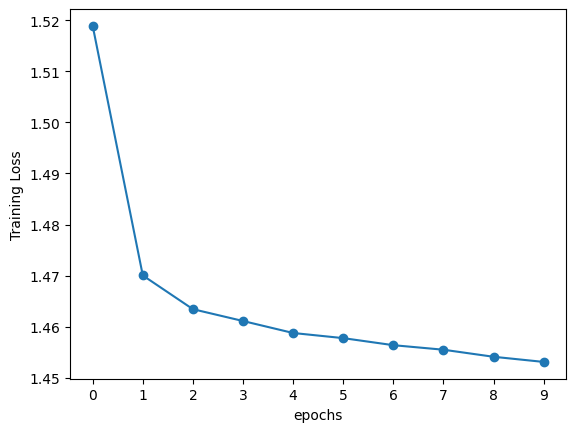

In [45]:
plot_metric_epochs(metric_values=logs_loss)

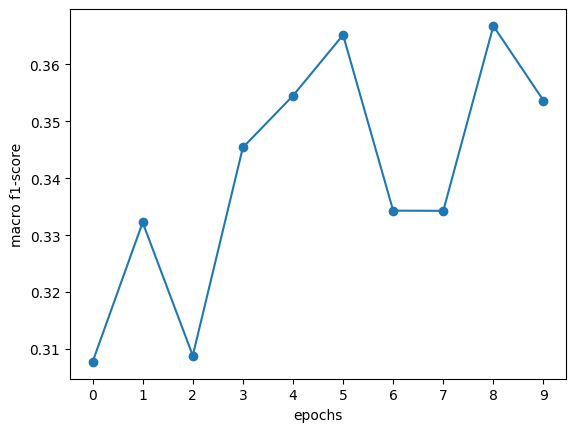

In [46]:
plot_metric_epochs(metric_values=logs_f1_score, y_label_name="macro f1-score")